In [5]:
# Bibliotecas
import os # para manipulação de arquivos
import numpy as np # para operações numéricas
import librosa # para processamento de áudio
import matplotlib.pyplot as plt # para criar gráficos e visualizações
import IPython.display as ipd # para reproduzir áudio diretamente no Jupyter Notebook
from scipy.signal import stft # short term fourier transform

# Módulos
from ruido import gerar_ruidos # arquivo python criado pra função de gerar ruído

In [6]:
# Exemplos
# exemplo = librosa.example('brahms') # peça de música clássica
exemplo = librosa.example('libri1') # leitura de livro
# exemplo = librosa.example('robin')    # som de pássaro

In [7]:
taxa_amostragem = 22050 # 22050 Hz é um valor de referência

# Carregamento de um audio de exemplo
audio, sr = librosa.load(exemplo, sr=None)  

ipd.Audio(data=audio, rate=taxa_amostragem) # reproduzir o áudio

In [8]:
audio_ruidoso = gerar_ruidos(
                audio = audio,
                taxa_amostragem = taxa_amostragem,
                intensidade_branco = 0.1,
                intensidade_rosa=0.03,
                intensidade_impulso = 0.03
                )

ipd.Audio(data=audio_ruidoso, rate=taxa_amostragem) # reproduzir o áudio

In [9]:
# Calcular STFT 
frequencias, tempos, matriz_stft = stft(audio, fs=taxa_amostragem, nperseg=1024) 
espectrograma_db = 20 * np.log10(np.abs(np.abs(matriz_stft)) + 1e-10) 

In [11]:
# Calcular STFT 
frequencias, tempos, matriz_stft = stft(audio_ruidoso, fs=taxa_amostragem, nperseg=1024) 
espectrograma_db_ruidoso = 20 * np.log10(np.abs(np.abs(matriz_stft)) + 1e-10) 

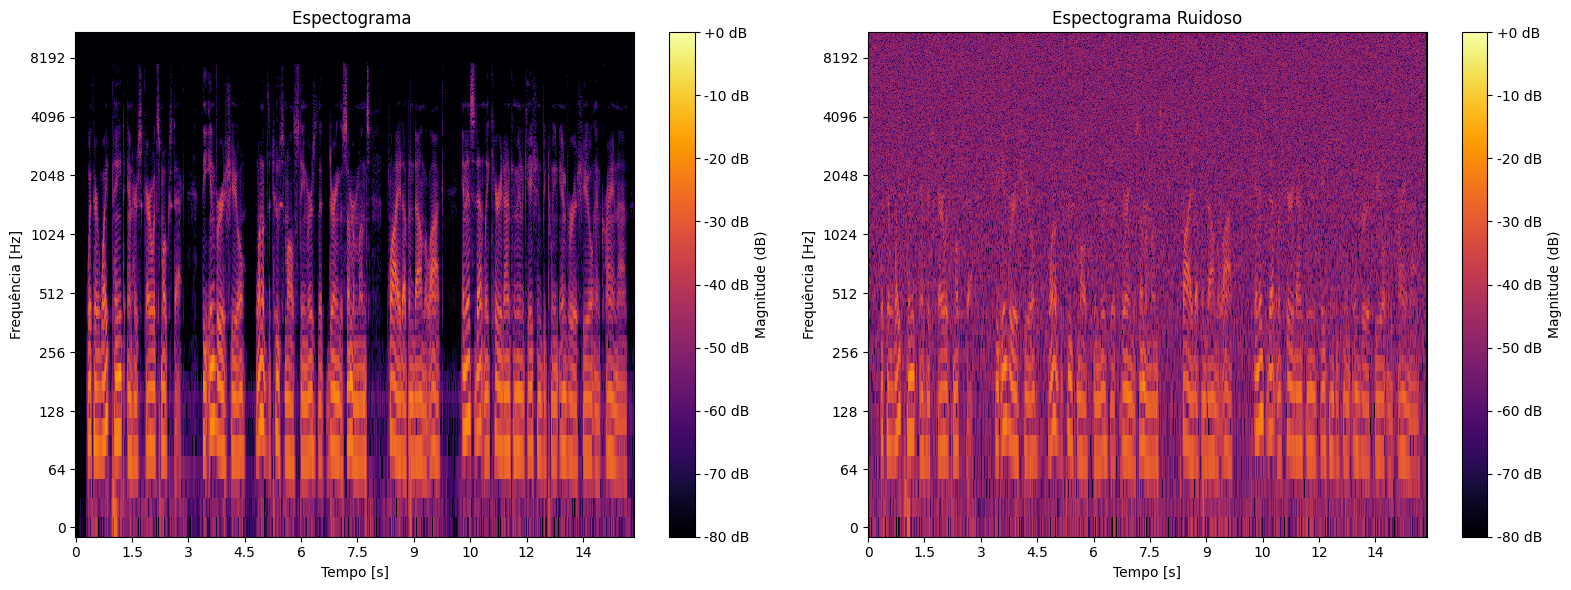

In [12]:
# Função para desenhar espectrograma
def plotar_espectrograma(S_db, sr, title="", ax=None):    
    img = librosa.display.specshow(S_db,
                                   sr=sr,
                                   hop_length=512,
                                   x_axis='time',
                                   y_axis='log',                                                                         
                                   cmap='inferno',
                                   vmin=-80, vmax=0,
                                   ax=ax)
    cbar = plt.colorbar(img, ax=ax, format='%+2.0f dB')
    cbar.set_label('Magnitude (dB)')
    ax.set_title("Espectograma"+" {}".format(title))
    ax.set_ylabel('Frequência [Hz]')
    ax.set_xlabel('Tempo [s]')

# Criar subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotar espectrograma original
plotar_espectrograma(espectrograma_db, taxa_amostragem, ax=axs[0])

# Plotar espectrograma ruidoso
plotar_espectrograma(espectrograma_db_ruidoso, taxa_amostragem, title="Ruidoso", ax=axs[1])

# Ajustar layout
plt.tight_layout()
plt.show()


In [13]:
def decomposicaoSVD(espectrograma, k=None):
    U, S, Vt = np.linalg.svd(espectrograma, full_matrices=False)
    U = U[:, :k]
    S = np.diag(S[:k])
    Vt = Vt[:k, :]
    return U, S, Vt

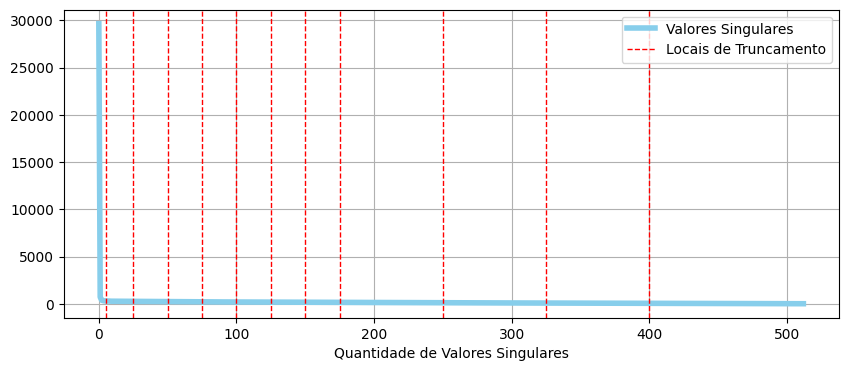

In [14]:
# Decomposição SVD do espectrograma
_, matriz_val_singulares, _ = decomposicaoSVD(espectrograma=espectrograma_db_ruidoso)

# Extrair os valores singulares
valores_singulares = np.diag(matriz_val_singulares)

# Criar o gráfico do espectro de valores singulares
plt.figure(figsize=(10, 4))
plt.plot(valores_singulares, color='skyblue', linewidth=4, label="Espectro de Valores Singulares")

# Adicionar grade ao gráfico
plt.grid(True)

# Adicionar linhas verticais pontilhadas para indicar locais de truncamento
locais_truncamento = [5, 25, 50, 75, 100, 125, 150, 175, 250, 325, 400]
for linha in locais_truncamento:
    plt.axvline(x=linha, color='red', linestyle='--', linewidth=1)

# Exibir legenda agrupada
plt.legend(['Valores Singulares', 'Locais de Truncamento'], loc='upper right')

# Exibir o gráfico
plt.xlabel('Quantidade de Valores Singulares')
plt.show()

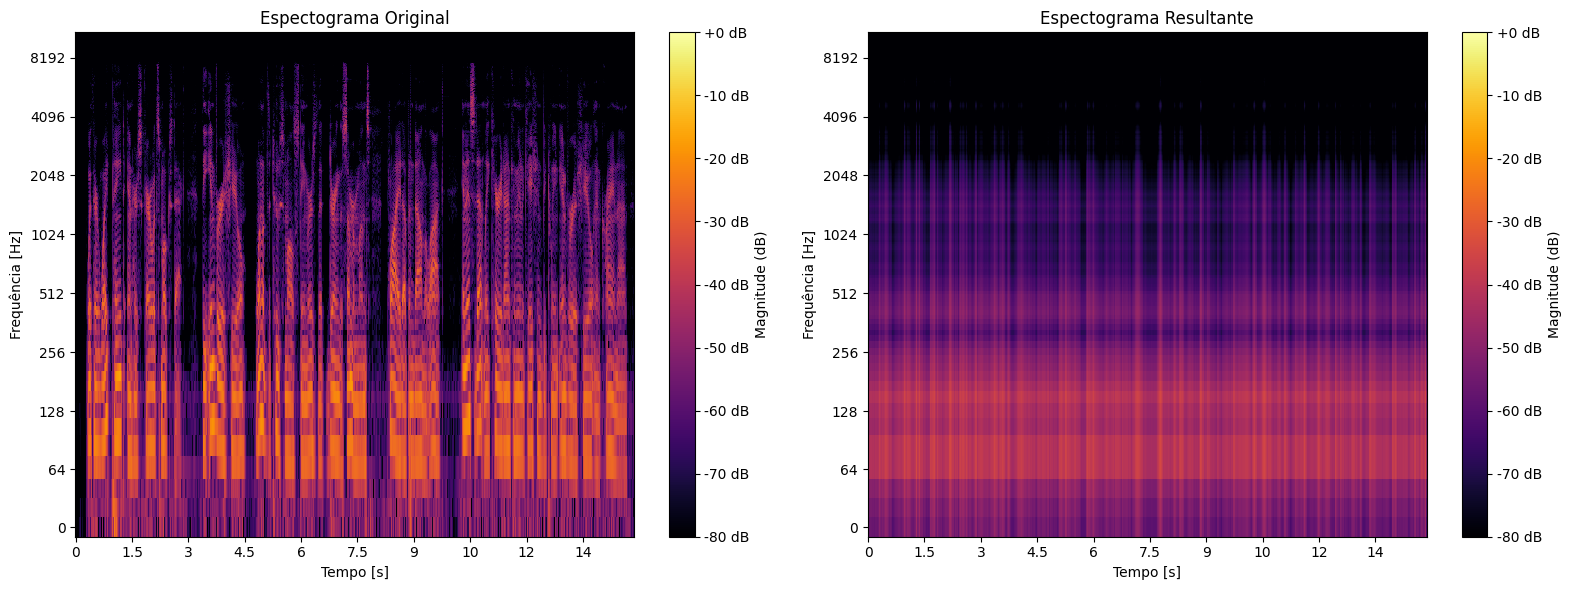

In [22]:
k = 1

U, S, Vt = decomposicaoSVD(espectrograma=espectrograma_db, k=k)
espectrograma_resultante = np.dot(U, np.dot(S, Vt))

# Criar subplots lado a lado
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

# Plotar espectrograma original
plotar_espectrograma(espectrograma_db, taxa_amostragem, title="Original", ax=axs[0])
# Plotar espectrograma resultante
plotar_espectrograma(espectrograma_resultante, sr=taxa_amostragem, title="Resultante", ax=axs[1])

# Ajustar layout
plt.tight_layout()
plt.show()

In [18]:
def play_from_spectrogram(magnitude, sr, n_iter=64):
    audio = librosa.griffinlim(magnitude, n_iter=n_iter)
    return ipd.Audio(data=audio, rate=sr)
play_from_spectrogram(espectrograma_resultante, sr=sr)